In [14]:
%load_ext autoreload
%autoreload 2

import plots
import runner
import analysis
import processing
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Replication of Meng et al. findings

Meng et al. setup for the 2 coupled network case:

* network with all-to-all coupling
* noisy-inputs to different neurons belonging to same or different network are uncorrelated
* IF neuron model
* input noise for a neuron is modeled as independent Poisson spike trains, mean rate is equal inside a network
* only inhibitory connections, gamma rhythm produced by ING mechanism
* local and global order parameter to measure synchrony

Observations
* with very weak noise: LFPs of different networks do not synchronize, they oscillate at different frequencies -> $r_{global}$ is small
* if noise increases at a certain point system jumps and global order parameter is significantly higher
* Reduction of noise leads now to increased desynchronization

Meng et al. main finding is that independent noise lead to synchronization across two networks

----

How can we replicate and extend with our current setup?

* two EI networks showing natural activity in gamma frequency band
* gamma produced by PING mechanism
* input noise also as Poisson Group per neuron
* compute local and global order parameter for one run
* parameter exploration with noise strength
* collect results and compare local and global order parameters
* generate plots for specific configurations as visual proof

## Model Configuration

In [2]:
# overwriting default parameters
params = {

  # synaptic coupling strengths, most important parameters for tuning PING mechanism
  "J_itoi": 5.,
  "J_etoe": .9,
  "J_etoi": 3.0,
  "J_itoe": 5.0,

  # Independent spike trains generated by Poisson Point Process for each target neuron
  "ext_input_type": "poisson",
  "poisson_strengths": [1.0, .5],

   # noise frequency ration between networks
  "poisson_p": 1.0,
  # 50 Hz rate as in Meng et. al. and decreasing with network index
  "poisson_rates": [30, 40],
  "poisson_size": 30,
   # mu = 200^-1
  "poisson_mean_input": 0.005,

  "J_ppee": 0.0,
  # increase from 0.1 to 0.2 increases mainly amplitude
  "J_ppei": 0.0,

  # if set to default of 0.1 this leads to strange split in frequency band
  "const_delay": 0.2,
  "N_pop": 2
}

pprint(params)

{'J_etoe': 0.9,
 'J_etoi': 3.0,
 'J_itoe': 5.0,
 'J_itoi': 5.0,
 'J_ppee': 0.0,
 'J_ppei': 0.0,
 'N_pop': 2,
 'const_delay': 0.2,
 'ext_input_type': 'poisson',
 'poisson_mean_input': 0.005,
 'poisson_p': 1.0,
 'poisson_rates': [30, 40],
 'poisson_size': 30,
 'poisson_strengths': [1.0, 0.5]}


In [3]:
model = runner.run(modified_params=params, file_name="meng-replication")

Initializing net ...
Initialization time: 0.8114838600158691s
==== Running Network ... ====
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 3s
==== Network Run Finished ====
runtime: 12.0


WARNING    Note that the synaptic pathway 'synapses_10_pre' will run on the clock of the group 'neurongroup_3' using a dt of 5e-05. Either the Synapses object 'synapses_10' or the target 'neurongroup_2' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 5e-05. If in doubt, try to ensure that 'neurongroup_3', 'synapses_10', and 'neurongroup_2' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]
WARNING    Note that the synaptic pathway 'synapses_11_pre' will run on the clock of the group 'neurongroup_3' using a dt of 5e-05. Either the Synapses object 'synapses_11' or the target 'neurongroup_3' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 5e-05. If in doubt, try to ensure that 'neurongroup_3', 'synapses_11', and 'neurongroup_3' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]
WARNING    Note 

In [4]:
if 'model' not in locals() or model is None:
    model = analysis.load_model("meng-replication")


## Model Visualization

Generate PSD plot ...
Generate PSD plot ...


(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13bdaa710>)

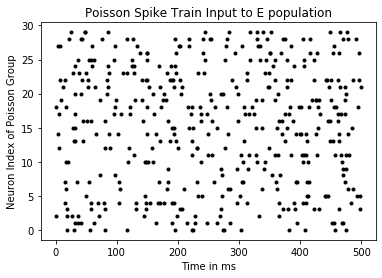

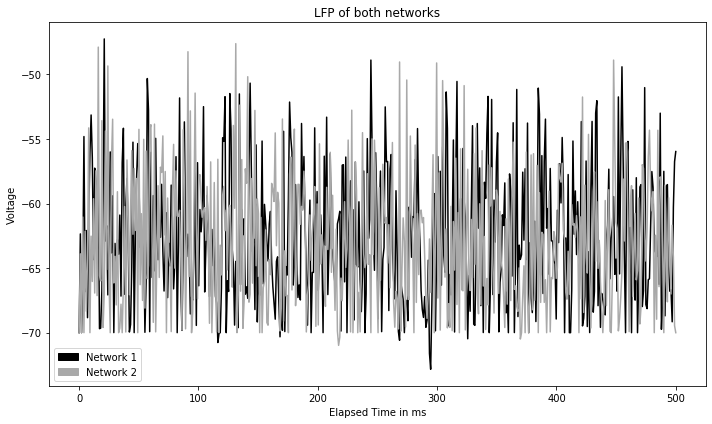

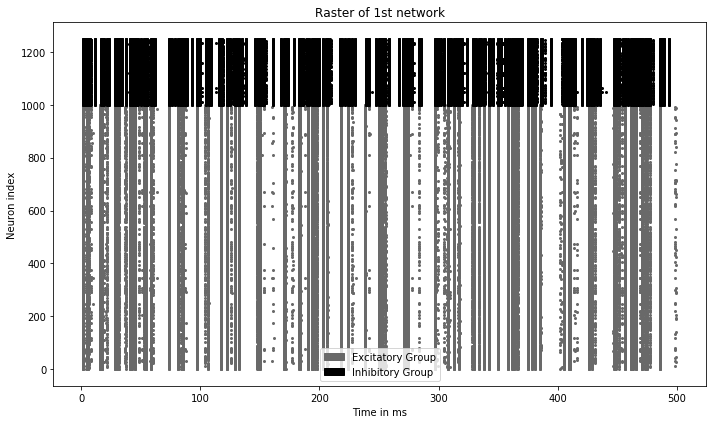

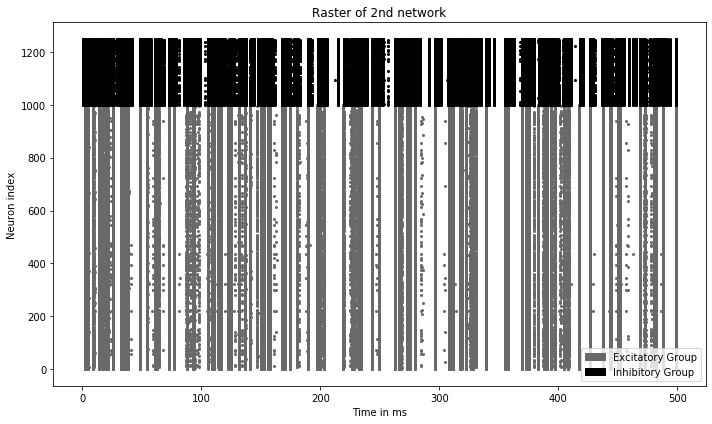

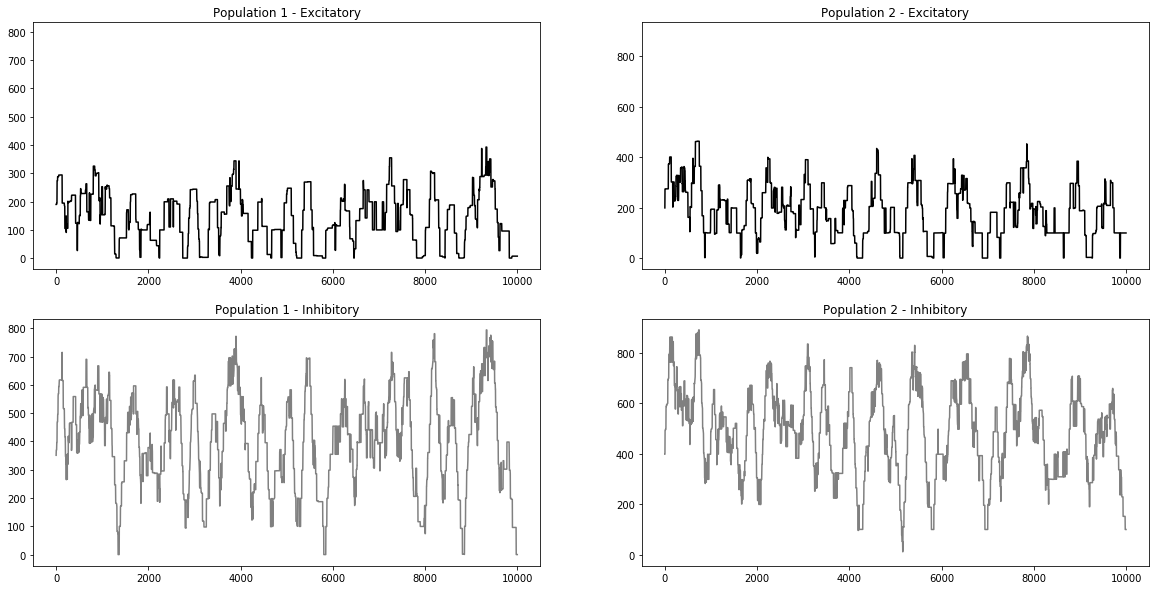

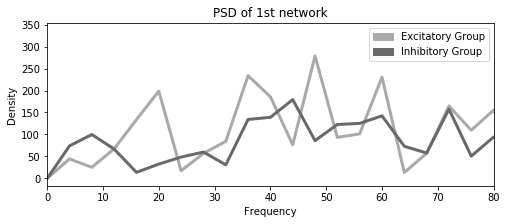

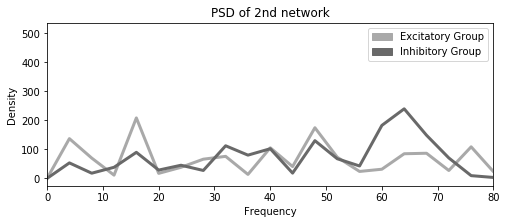

In [15]:
plots.poisson_input(model)

plots.lfp_nets(model)

plots.raster(title="Raster of 1st network", model=model)
plots.raster(title="Raster of 2nd network", model=model, population=2)

plots.population_rates(model)

plots.psd(model, title="PSD of 1st network")
plots.psd(model, title="PSD of 2nd network", population=2)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13be4f6d8>)

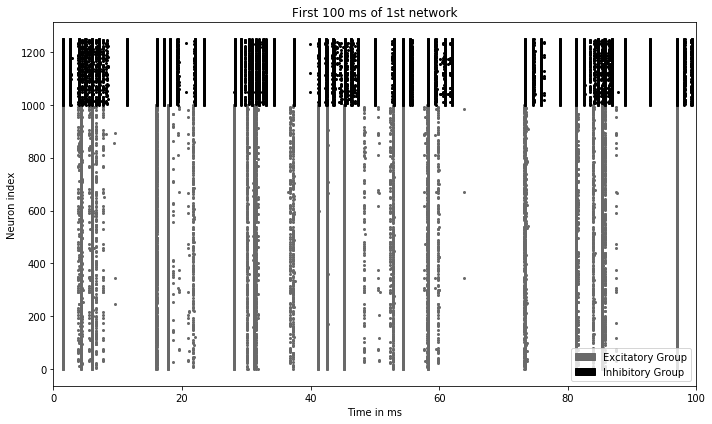

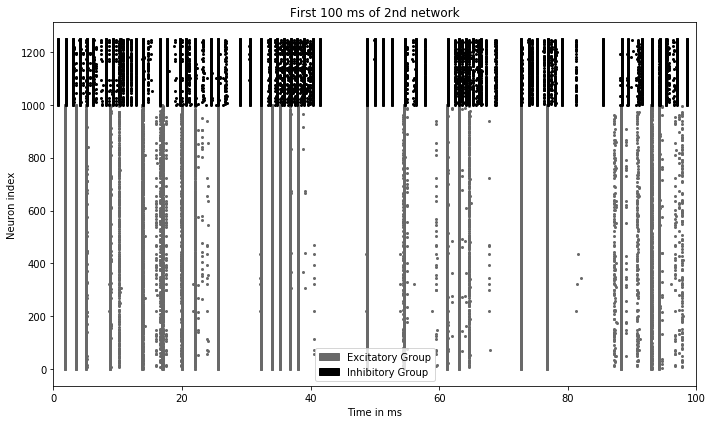

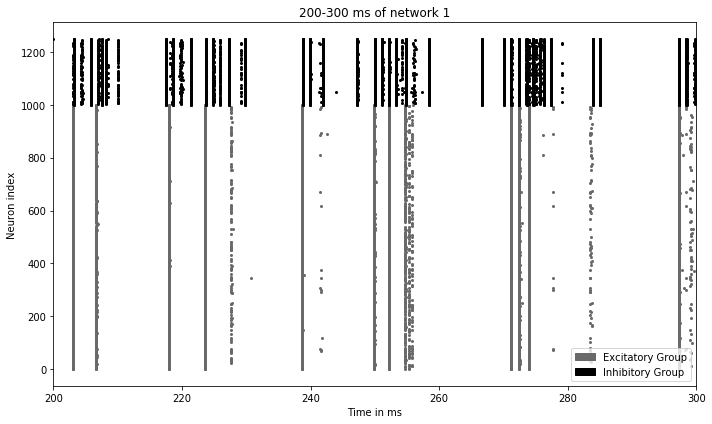

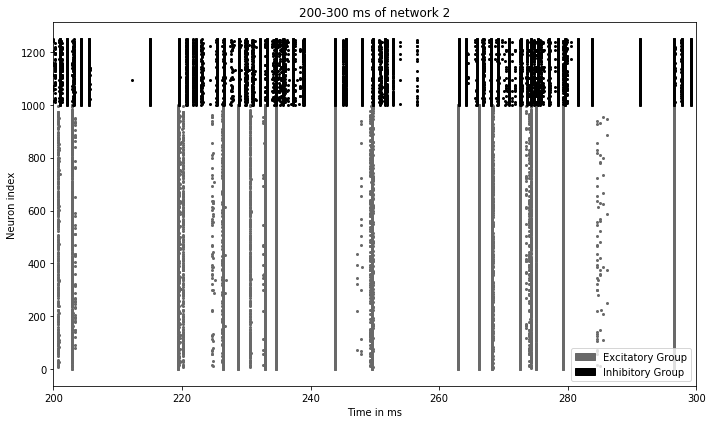

In [6]:
plots.raster(title="First 100 ms of 1st network", model=model, x_left=0, x_right=100)
plots.raster(title="First 100 ms of 2nd network", model=model, x_left=0, x_right=100, population=2)

plots.raster(title="200-300 ms of network 1", model=model, x_left=200, x_right=300)
plots.raster(title="200-300 ms of network 2", model=model, x_left=200, x_right=300, population=2)


## Synchronization Analysis

Meng et al. computes two different order parameters.

The global order parameter and the local order parameter.

How to calculate the **global order** parameter?

* calculate the LFPs of each network
* use LFP as input to measure phase synchronization

How to calculate the **local order** parameter?

* use signal of every neuron in a network as input
* calculate

Considerations:
* There are different ways to obtain the Phase of an oscillator. We use here the Hilbert transformation to obtain the analytical signal.
However, currently we use the raw signal, so the question is if we should filter the signal to get a cleaner representation?
* Meng et al. mention that in the IF-model the voltage trace $V(t)$ does not include the action potential itself, therefore they add a spike of $45 mV$ manually.
Do we have the same case in our model?
* Meng et al. used only inhibitory connections and oscillations in the gamma band are caused by the ING mechanism. For a perfectly synchronized ING-rhythm we expect **all** neurons to fire in total synchrony. However, in PING we have an interplay between pyramidal neurons (excitatory) and interneurons (inhibitory). Thus, in a state of perfect synchrony we expect a small phase difference between the excitatory group and the ihibitory group. Considering this, the order parameter would never reach optimal value as we always have phase differences between the two groups. However, we could alter the order parameter by computing average phase synchronization for excitatory and inhibitory group seprately and then again use the average of both groups as measure for within-synchronization in the network.


In [16]:
lfps = processing.lfp_nets(model)
global_order_parameter = processing.order_parameter_over_time(lfps)

total_value = np.mean(global_order_parameter)
print(f"Global Order Parameter value of: {total_value}")

Global Order Parameter value of: 0.6182122452180351


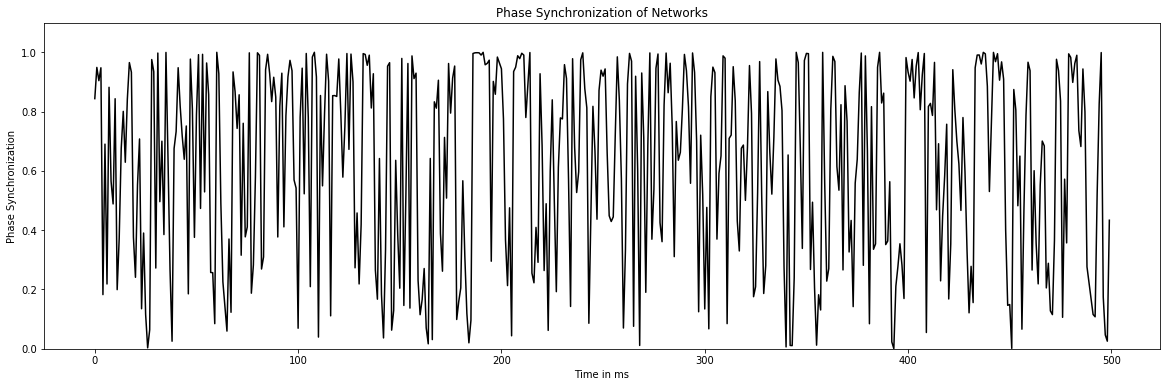

In [17]:
plt.figure(figsize=(20, 6))
plt.title(f"Phase Synchronization of Networks")
plt.xlabel("Time in ms")
plt.ylim(0, 1.1)
plt.ylabel("Phase Synchronization")
plt.plot(global_order_parameter, c="black")

In [18]:
print("Computing within synchronization for network 1 and 2")

neurons_net_1 = np.vstack((
    model['model_results']['net']['v_all_neurons_e'],
    model['model_results']['net']['v_all_neurons_i1']
))

neurons_net_2 = np.vstack((
    model['model_results']['net']['v_all_neurons_e2'],
    model['model_results']['net']['v_all_neurons_i2']
))

plv_net_1 = processing.order_parameter_over_time(neurons_net_1)
plv_net_2 = processing.order_parameter_over_time(neurons_net_2)

Computing within synchronization for network 1 and 2


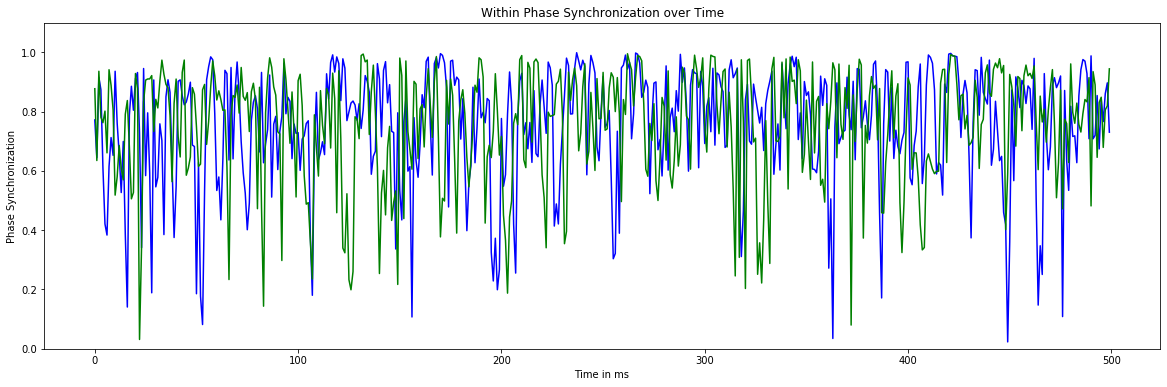

In [10]:
plt.figure(figsize=(20, 6))
plt.title(f"Within Phase Synchronization over Time")
plt.xlabel("Time in ms")
plt.ylim(0, 1.1)
plt.ylabel("Phase Synchronization")
plt.plot(plv_net_1, c="blue")
plt.plot(plv_net_2, c="green")

In [11]:
# plt.axes(polar=True)
# plt.title("Phase Distribution")
#
# for angle in phases[:50]:
#     plt.plot((0, angle[10]), (0, np.abs(angle[10])), c="black")

# plot the average phase vector
# length of vector expresses the synchronization, [0-1].
# plt.plot((0, avg[10]), (0, phi[10]), c='red')
# plt.show()